# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

<div class="span5 alert alert-info">
### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution
</div>
****

In [151]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [152]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [153]:
data.to_csv('discrimination.csv')

In [154]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


In [155]:
data.shape

(4870, 65)

In [156]:
w = data[data.race=='w']
b = data[data.race=='b']
print('There are ',len(b), 'resumes with black-sounding names and ', len(w), 'resumes with white-sounding names.')


There are  2435 resumes with black-sounding names and  2435 resumes with white-sounding names.


In [157]:
# number of callbacks for black-sounding names
b_callbacks = sum(data[data.race=='b'].call)
b_callbacks

157.0

In [158]:
# number of callbacks for white-sounding names
w_callbacks = sum(data[data.race=='w'].call)
w_callbacks

235.0

In [159]:
# black-sounding name callback proportion
b_prop = b_callbacks/len(b)
b_prop

0.06447638603696099

In [172]:
np.mean(b_callbacks)

157.0

In [160]:
# white-sounding name callback proportion
w_prop = w_callbacks/len(w)
w_prop

0.09650924024640657

### 1. What test is appropriate for this problem? Does CLT apply?

An appropriate test for this problem is a two-sample hypothesis test comparing two proportions.

The central limit theorem applies to binomial distributions as long as the minumum of np and n(1-p) is at least 5. For the total data set, np  (4870 * .08) = 390, and  n(1-p) = 4480   (4870(1-.08).  Both numbers are above the minimum of 5, thus the central limit theorem applies.

### 2. What are the null and alternate hypotheses?

Null Hypothesis:  There is no difference in the proportion of call-backs between resumes with black-sounding names and white-sounding names.

Alternate Hypothesis: There is a difference in the proportion of call-backs between resumes with black-sounding names and white-sounding names.

### 3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

#### Bootstrap Test

In [161]:
def diff_prop(data_a, data_b):
    prop_a = np.sum(data_a) / len(data_a)
    prop_b = np.sum(data_b) / len(data_b)
    return prop_b - prop_a

In [162]:
#Compute observed value of test statistic
diff_prop_obs = diff_prop(b.call, w.call)
diff_prop_obs

0.032032854209445585

In [163]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    
    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))
    
    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(call_all)
    
    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    
    return perm_sample_1, perm_sample_2

In [164]:
perm_sample_1, perm_sample_2 = permutation_sample(b.call, w.call)

In [166]:
def permutation_replicate(data_a, data_b, func):
    perm_sample_1, perm_sample_2 = permutation_sample(data_a, data_b)
    test_statistic = func(perm_sample_1, perm_sample_2)
    return test_statistic

In [167]:
perm_replicates = np.empty(10000)

for i in range(10000):
    perm_replicates[i] = permutation_replicate(b.call, w.call, diff_prop)
    
p_value = np.sum(perm_replicates >= diff_prop_obs) / 10000

p_value

0.0

In [168]:
max(perm_replicates)

0.030390143737166322

The p-value is zero, and indeed none of the 10,000 permutation replicates produced a difference in proportion as great as the difference of .036 observed in the data.  The null hypothesis can be rejected.

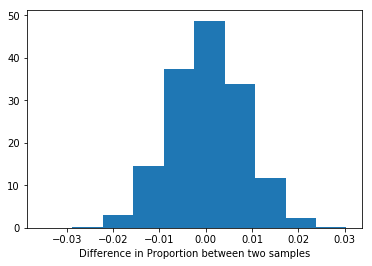

In [169]:
plt.hist(perm_replicates, density = True)
plt.xlabel('Difference in Proportion between two samples')
plt.show()

#### Margin of Error

In [170]:
margin_of_error = np.std(perm_replicates)
margin_of_error

0.007873745846781632

The margin of error is 0.0077

#### Confidence Interval

In [171]:
conf_int = np.percentile(perm_replicates, [2.5, 97.5])
conf_int

array([-0.01560575,  0.01480493])

The confidence interval is (-0.015, 0.015)

#### Frequentist Tests

In [175]:
# Standard deviation of difference between samples
std_dev = np.sqrt((b_prop*(1-b_prop)/len(b))+(w_prop*(1-w_prop)/len(w)))
std_dev

0.0077833705866767544

In [188]:
# Mean of difference between samples
mean = b_prop - w_prop
mean

-0.032032854209445585

In [189]:
z_score = mean / std_dev
z_score

-4.11555043573

In [193]:
p_value = stats.norm.sf(abs(z_score))*2
p_value

3.862565207522622e-05

In [187]:
# T-Test
t_stat, p_value = stats.ttest_ind(b.call, w.call)
p_value

3.940802103128886e-05

The Z-test and t-test both give very low p-values and we can reject the null hypothesis.

### 4. Write a story describing the statistical significance in the context or the original problem.

The collected data shows that callback rates for white-sounding names is about 9.6 % , while it is only 6.4 % for black-sounding names.  The analysis shows that this is a statistically significant difference that is very unlikely to occur based on chance, strongly indicating racial discrimination in the hiring process.

### 5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

This anlaysis did not look at any other variables, and thus can not determine their relative importance to callback success. The analysis could be amended to test the other variables to determine which others might be important factors in callback success, and once other important variables have been identified, their importance relative to race could be examined. Because the number of variables is so high, a quicker way to determine the relative importance is to create a regression model and look at the coefficients.